In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import torch.nn.functional as F
import torch.nn as nn

In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
mpl.rcParams['image.cmap'] = 'gray'


In [0]:
def get_data():
  path=datasets.download_data(MNIST_URL,ext='.gz')
  with gzip.open(path,'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
  return map(tensor,(x_train,y_train,x_valid,y_valid))
             
def normalize(x,m,s): return (x-m)/s

In [0]:
x_train,y_train,x_valid,y_valid=get_data()

In [0]:
y_train.shape

torch.Size([50000])

In [0]:
train_mean=x_train.mean()
train_std=x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [0]:
x_train=normalize(x_train,train_mean,train_std)
x_valid=normalize(x_valid,train_mean,train_std)

In [0]:
x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [0]:
x_train.shape

torch.Size([50000, 784])

In [0]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [0]:
class Model(nn.Module):
  def __init__(self,n_in,nh,out):
    super().__init__()
    self.layers=[nn.Linear(n_in,nh),nn.ReLU(),nn.Linear(nh,out)]
  
  def forward(self,x):
    for l in self.layers: x=l(x)
    return x

In [0]:
model=Model(m,nh,10)

In [0]:
pred=model(x_train)

In [0]:
pred

tensor([[-0.2996,  0.1153, -0.2129,  ...,  0.0504,  0.3339, -0.1749],
        [-0.1461,  0.4471, -0.2552,  ..., -0.2042,  0.1335,  0.0118],
        [ 0.0625, -0.0144, -0.0996,  ..., -0.3513,  0.0708, -0.4427],
        ...,
        [-0.2463, -0.0424, -0.2848,  ..., -0.0287,  0.2876,  0.0141],
        [-0.1498,  0.1510, -0.1929,  ..., -0.1134,  0.3525,  0.1231],
        [-0.2428, -0.1341, -0.3161,  ..., -0.0396,  0.1378, -0.2096]],
       grad_fn=<AddmmBackward>)

In [0]:
loss_func = F.cross_entropy


In [0]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()


In [0]:
bs=128

x=x_train[:bs]
pred=model(x)
pred[0],pred.shape

(tensor([-0.2996,  0.1153, -0.2129,  0.1925,  0.1272, -0.0355, -0.1058,  0.0504,
          0.3339, -0.1749], grad_fn=<SelectBackward>), torch.Size([128, 10]))

In [0]:
yb=y_train[:bs]
loss_func(pred,yb)
pred.shape,yb.shape

(torch.Size([128, 10]), torch.Size([128]))

In [0]:
accuracy(pred,yb)

tensor(0.0859)

In [0]:
lr=0.005
epoch=10

In [0]:
for epoch in range(epoch):
  for i in range((n-1)//bs +1):
    start_i=i*bs
    end_i=start_i+bs
    xb=x_train[start_i:end_i]
    yb=y_train[start_i:end_i]
    loss=loss_func(model(xb),yb)
    
    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l,'weight'):
          l.weight -= l.weight.grad * lr
          l.bias   -= l.bias.grad   * lr
          l.weight.grad.zero_()
          l.bias  .grad.zero_()

In [0]:
loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

(tensor(0.1272, grad_fn=<NllLossBackward>), tensor(0.9635))

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.1): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
opt=Optimizer(model.parameters())

In [0]:
for epoch in range(2):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

(tensor(0.3666, grad_fn=<NllLossBackward>), tensor(0.8965))

In [0]:
from torch import optim

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [0]:
??optim.SGD.step

In [0]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3693, grad_fn=<NllLossBackward>)

In [0]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [0]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)


In [0]:
for epoch in range(4):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
class DataLoader():
  def __init__(self,ds,bs):
    self.ds=ds
    self.bs=bs
  def __iter__(self):
    for i in range(0,len(self.ds),self.bs): yield self.ds[i:i+self.bs]

In [0]:

train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

tensor(3)

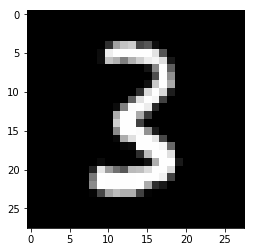

In [0]:

plt.imshow(xb[0].view(28,28))
yb[0]

In [0]:

model,opt = get_model()

In [0]:
def fit():
    for epoch in range(5):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [0]:
fit()

In [0]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)


In [0]:
class Sampler():
  def __init__(self,ds,bs,shuffle=False):
    self.n=len(ds)
    self.bs=bs
    self.shuffle=shuffle
    
  def __iter__(self):
    self.idxs=torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
    for i in range(0,self.n,self.bs): yield self.idxs[i:i+self.bs]

In [0]:
small_ds=Dataset(*(train_ds[:10]))

In [0]:
s=Sampler(small_ds,3,True)

[o for o in s]

[tensor([6, 4, 8]), tensor([2, 5, 1]), tensor([7, 3, 9]), tensor([0])]

In [0]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)
  
class DataLoader():
  def __init__(self,ds,sampler,collate_fn=collate):
    self.ds=ds
    self.sampler=sampler
    self.collate_fn=collate_fn
    
  def __iter__(self):
    for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])
    

In [0]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
  def __init__(self, ds, sampler, collate_fn=collate):
    self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
  def __iter__(self):
    for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [0]:
train_samp=Sampler(train_ds,bs,True)
valid_samp=Sampler(valid_ds,bs,False)

In [0]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

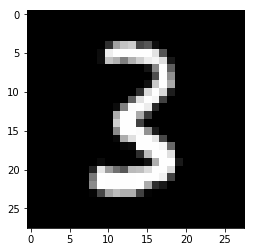

In [0]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

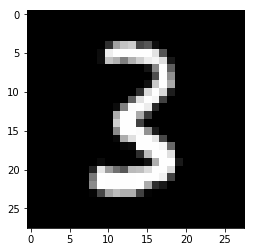

In [0]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(7)

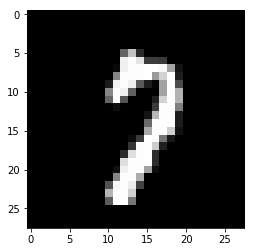

In [0]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

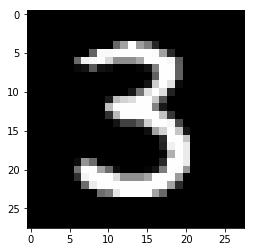

In [0]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [0]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid)

In [0]:
loss

tensor(0.3091, grad_fn=<NllLossBackward>)

In [0]:
acc

tensor(0.9114)

In [0]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler


In [0]:
??Dataset

In [0]:

x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [0]:
train_dl.dataset.x.shape

torch.Size([50000, 784])

In [0]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
data = DataBunch(train_dl, valid_dl, c)


In [0]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:

learn = Learner(*get_model(data), loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:

loss,acc = fit(3, learn)

0 tensor(0.1494) tensor(0.9571)
1 tensor(0.1191) tensor(0.9635)
2 tensor(0.1213) tensor(0.9626)


In [0]:
def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb,yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()

def all_batches(dl, cb):
    for xb,yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop(): return

def fit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

In [0]:

class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True


In [0]:

class CallbackHandler():
    def __init__(self,cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        self.learn,self.in_train = learn,True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train=True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:     return self.learn.stop
        finally: self.learn.stop = False

In [0]:
class TestCallback(Callback):
    def begin_fit(self,learn):
        super().begin_fit(learn)
        self.n_iters = 0
        return True
        
    def after_step(self):
        self.n_iters += 1
        print(self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
        return True

In [0]:
fit(1, learn, cb=CallbackHandler([TestCallback()]))


In [0]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)